In [1]:
import os
import sys
from google.colab import drive
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
import dlib
from scipy import ndimage
import tarfile
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%mkdir -p /content/data/
%cd /content/data

train_path = '/content/drive/My Drive/training/training.tar'
val_path = '/content/drive/My Drive/training/validation.tar'
test_path = '/content/drive/My Drive/training/test.tar'
train_full_path = '/content/drive/My Drive/training/train_full.tar'
val_full_path = '/content/drive/My Drive/training/val_full.tar'

# Load training set, validation set and test set
for fpath in [train_full_path, val_full_path, test_path]:
  print('Extracting {}...'.format(fpath.split('/')[-1]))
  with tarfile.open(fpath) as tar:
    tar.extractall()

/content/data
Extracting train_full.tar...
Extracting val_full.tar...
Extracting test.tar...


## **Image Preprocessing**

In [4]:
import os

import cv2
import dlib
import numpy as np
from PIL import Image


class align_faces(object):

    def __call__(self, image):

        # Since the images are loaded it PIL
        image = np.asarray(image)

        # The percentage value of how far in the picture the left eye should be
        LEFT_EYE_CORD = (0.25, 0.2)
        DIMENSIONS = 244

        train_folder = '/content/drive/My Drive/training/'
        predictor_path = os.path.join(train_folder, "shape_predictor_5_face_landmarks.dat")
        detector_path = os.path.join(train_folder, "mmod_human_face_detector.dat")
        shape_predictor = dlib.shape_predictor(predictor_path)
        face_detector = dlib.get_frontal_face_detector()

        # changed here for efficiency
        # face_detector = dlib.cnn_face_detection_model_v1(detector_path)
        faces = face_detector(image)

        if not faces:
            raise ValueError("Image has no detectable faces")

        # assumption is made that there is only one
        for face in faces:
          # face = face_rect.rect
          landmarks = shape_predictor(image, face)
          landmarks = landmarks.parts()
          landmarks = self.convert_to_np(landmarks)

          # To Gauge Scale
          maximum = np.max(landmarks, axis=0)
          minimum = np.min(landmarks, axis=0)

          # eye landmarks
          right = landmarks[:2]
          left = landmarks[2:4]

          left = np.mean(left, axis=0, dtype=np.int)
          right = np.mean(right, axis=0, dtype=np.int)

          centre = np.vstack((left, right))
          centre = np.mean(centre, axis=0, dtype=np.int)

          diff = right - left
          diff = diff.reshape((2, 1))

          angle = np.degrees(np.arctan2(diff[1], diff[0]))

          # find the length of the face, and use that for our scale
          y_scale = maximum[1] - minimum[1]
          y_scale = y_scale + 2.1 * y_scale

          M = cv2.getRotationMatrix2D((centre[0], centre[1]), angle, DIMENSIONS / y_scale)

          # update translation
          t_x = DIMENSIONS // 2
          t_y = DIMENSIONS * LEFT_EYE_CORD[1]
          M[0, 2] += (t_x - centre[0])
          M[1, 2] += (t_y - centre[1])

          image2 = cv2.warpAffine(image, M, (DIMENSIONS, DIMENSIONS),
                                  flags=cv2.INTER_CUBIC)

          # convert back to PIL
          return Image.fromarray(image2)

    @staticmethod
    def convert_to_np(points):
        np_points = np.array([], dtype=np.int)
        while points:
            point = points.pop()
            np_points = np.append(np_points, (point.x, point.y))

        np_points = np_points.reshape((-1, 2))
        np_points = np.flip(np_points, axis=0)
        return np_points

In [5]:
transform = torchvision.transforms.Compose(
    [torchvision.transforms.Grayscale(num_output_channels=3), 
     align_faces(),
     torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.3898, 0.3884, 0.3878), (0.2433, 0.2430, 0.2430))
     ]
)

## **Dataset Creation**

In [6]:
class AUDataset(Dataset):
  """ CK+ dataset labeled by the presence of action units (AU) """
  
  def __init__(self, mode='train', fold=0, transform=None):
    """
    Args:
      - label_csv: Path to the csv file with action unit labels.
      - mode: one of 'train', 'validate', and 'test'
      - fold: one of 0, 1, and 2; determines which folds to use for training
      - transform: transform applied to an image input
    """
    try:
      path_dict = {
          'train': 'training/train_data_',
          'validate': 'validation/valid_data_',
          'test': 'test/test_data',
          'train_full': 'train_full/train_full_data',
          'validate_full': 'val_full/val_full_data'
      }
      fold = fold if ((mode == 'train') or (mode == 'validate')) else ''
      self.data_path = '{}{}'.format(path_dict[mode], fold)
      self.label_path = '{}{}_labels.csv'.format(path_dict[mode], fold)
    except KeyError:
      raise ValueError('{} is not a valid mode. Choose train, validation, or test.'.format(mode))
    self.au_frame = pd.read_csv(self.label_path)
    self.label_cols = ['AU_1', 'AU_2', 'AU_4', 'AU_5', 'AU_6', 'AU_7', 
                        'AU_9', 'AU_10', 'AU_12', 'AU_14', 'AU_15', 'AU_17',
                        'AU_20', 'AU_23/24', 'AU_25', 'AU_26/27', 'AU_28',
                        'AU_43']
    self.transform = transform
    

  def __len__(self):
    return len(self.au_frame)

  def __getitem__(self, idx):
    # Get image at idx
    image_id = self.au_frame.iloc[idx]['path']
    image_path = self.data_path + '/' + image_id
    image = cv2.imread(image_path)
    try:
      image = Image.fromarray(image)
    except AttributeError:
      raise ValueError('{} not found'.format(image_path))

    # Get AU labels
    aus = self.au_frame.iloc[idx][self.label_cols]
    aus = np.array(aus, dtype=float)

    if self.transform:
      try:
        image = self.transform(image)
      except ValueError: # No faces were detected
        return None

    sample = {'image': image, 'labels': aus}

    return sample

## **Other Useful Functions**

In [7]:
def collate_fn(batch):
    """
    Used to process the list of samples to form a batch. Ignores images
    where no faces were detected.
    """
    batch = list(filter(lambda x: x is not None, batch))
    return torch.utils.data.dataloader.default_collate(batch)

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap="gray")
    plt.show()

## **Scoring Metrics**

In [8]:
from sklearn.metrics import f1_score, precision_score, recall_score, auc, precision_recall_curve

def get_metrics(model, data):
  """
  Compute the f1 score for each action unit (AU).
  """
  labels = np.array([], dtype=int).reshape(0,18)
  preds = np.array([], dtype=int).reshape(0,18)
  model.eval() # Set to evaluation mode
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  model.to(device)

  with torch.no_grad():
    for _, item in enumerate(data, 0):
      batch_labels = item.get("labels")
      labels = np.vstack([labels, batch_labels])
      imgs = item.get("image")
      imgs = imgs.to(device)
      outputs = model(imgs).cpu().detach()
      outputs = torch.sigmoid(outputs).numpy()
      preds = np.vstack([preds, outputs])
  
  # Compute f1 scores
  f1_scores = []
  pres_scores = []
  recall_scores = []
  pr_auc_scores = []
  for au in range(18):
    au_labels = labels[:, au]
    au_preds = preds[:, au]
    p, r, _ = precision_recall_curve(au_labels, au_preds)
    auc_pr = auc(r, p)
    if np.isnan(auc_pr):
      auc_pr = 0
    pr_auc_scores.append(auc_pr)


    # Threshold probabilities > 0.4 to 1 for other metrics
    if au == 17:
      au_preds = (au_preds > 0.05) * 1
    else:
      au_preds = (au_preds > 0.4) * 1
    f1 = f1_score(au_labels, au_preds, zero_division=0); f1_scores.append(f1)
    precision = precision_score(au_labels, au_preds, zero_division=0)
    pres_scores.append(precision)
    recall = recall_score(au_labels, au_preds, zero_division=0)
    recall_scores.append(recall)
  return pres_scores, recall_scores, f1_scores, pr_auc_scores


## **Final Model Training**

In [10]:
import copy
import time

import torchvision
from scipy.io.idl import AttrDict
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np


def validation_step(convnet, val_loader, criterion, bs):
  num_matches = 0.0
  total = 0.0
  losses = []
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  with torch.no_grad():
      for _, item in enumerate(val_loader, 0):

          labels = item.get("labels")
          imgs = item.get("image")
          labels = labels.to(device)
          imgs = imgs.to(device)

          outputs = convnet(imgs)

          # Compute batch loss
          val_loss = criterion(outputs, labels)
          losses.append(val_loss.data.item())

          # Compute batch accuracy, set probabilities > 0.5 to 1
          t = torch.Tensor([0.5])
          t = t.to(device)
          num_matches += ((torch.nn.functional.sigmoid(outputs) > t) == labels).sum()

          total += labels.size(0) * 18

  val_loss = np.mean(losses)
  val_acc = 100 * num_matches / total
  return val_loss, val_acc


def train(convnet, args):
  """Training loop for a single validation fold."""
  train_losses = []
  valid_losses = []
  valid_accs = []
  best_loss = -100 
  start = time.time()

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  best_model_wts = copy.deepcopy(convnet.state_dict())

  train_set = AUDataset(mode='train_full', transform=args.transform)
  train_loader = DataLoader(train_set, args.batch_size, collate_fn=collate_fn,
                            shuffle=True, num_workers=args.num_workers)
  
  val_set = AUDataset(mode='validate_full', transform=args.transform)
  val_loader = DataLoader(val_set, args.batch_size, collate_fn=collate_fn,
                          shuffle=True, num_workers=args.num_workers)

  optimizer = torch.optim.Adam(convnet.parameters(), args.learn_rate)
  criterion = torch.nn.BCEWithLogitsLoss()

  if args.resume: 
    print("Loading checkpoint")
    state = torch.load(args.checkpoint)
    convnet.load_state_dict(state['model_state_dict'])
    optimizer.load_state_dict(state['optimizer_state_dict'])


  for epoch in range(args.epochs):
      convnet.train()
      losses = []

      for _, item in enumerate(train_loader, 0):
          
          labels = item.get("labels")
          imgs = item.get("image")

          labels = labels.to(device)
          imgs = imgs.to(device)

          optimizer.zero_grad()

          outputs = convnet(imgs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          losses.append(loss.data.item())


      avg_loss = np.mean(losses)
      train_losses.append(avg_loss)
      time_elapsed = time.time() - start

      print('Epoch [%d/%d], Loss: %.4f, Time (s): %d' % (
          epoch + 1, args.epochs, avg_loss, time_elapsed))
      
      # Validation 
      convnet.eval()
      val_loss, val_acc = validation_step(convnet, val_loader, criterion,
                                          args.batch_size)
      time_elapsed = time.time() - start
      valid_losses.append(val_loss)
      valid_accs.append(val_acc)

      print('Epoch [%d/%d], Val Loss: %.4f, Val Acc: %.1f%%, Time(s): %.2f' % (
          epoch + 1, args.epochs, val_loss, val_acc, time_elapsed))

      # Save model
      if -val_loss >= best_loss:
        print("Best Loss: Saving Model")
        best_loss = -val_loss
        checkpoint = {
              'model_state_dict': convnet.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'train_losses': train_losses,
              'valid_losses': valid_losses,
              'best_val_loss': best_loss
          }
        torch.save(checkpoint, args.checkpoint)


def match_state_dict(state_dict):
  """
  Renames 'fc.0' to 'fc.1' and 'fc.2' to 'fc.3' in order to load pretrained
  model weights to new model.
  """
  new_sd = copy.deepcopy(state_dict)
  for key in state_dict:
    if 'fc' in key:
      layer, num, weight = key.split('.')
      if int(num) == 0:
        new_sd['{}.1.{}'.format(layer, weight)] = new_sd.pop(key)
      elif int(num) == 2:
        new_sd['{}.3.{}'.format(layer, weight)] = new_sd.pop(key)
  return new_sd

def get_model(path):
  """
  Returns a model that has already been pretrained on the CelebA dataset.
  """
  model = models.resnet18(pretrained=True)
  num = model.fc.in_features
  fc = torch.nn.Sequential(
      torch.nn.LeakyReLU(),
      torch.nn.Linear(512, 256), 
      torch.nn.LeakyReLU(),
      torch.nn.Linear(256, 18))
  
  model.fc = fc
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  last_cp = torch.load(path)
  model_state_dict = match_state_dict(last_cp['model_state_dict'])
  model.load_state_dict(model_state_dict)
  model = model.to(device)
  return model

In [ ]:
args = AttrDict()
args_dict = {
    'gpu': True,
    'transform': transform,
    'checkpoint': '/content/drive/MyDrive/training/checkpoints/final.pt',
    'learn_rate': 0.0001,
    'batch_size': 33,
    'epochs': 12,
    'num_workers': 4,
    'resume': False 
}

args.update(args_dict)
convnet = get_model('/content/drive/My Drive/training/876.pt')

# Freeze feature map layers
for name, param in convnet.named_parameters():
  if ('fc' in name) or ('layer4' in name):
    param.requires_grad = True
  else:
    param.requires_grad = False
train(convnet, args=args)

Epoch [1/12], Loss: 0.4340, Time (s): 221


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch [1/12], Val Loss: 0.1931, Val Acc: 93.4%, Time(s): 236.19
Best Loss: Saving Model
Epoch [2/12], Loss: 0.1655, Time (s): 458
Epoch [2/12], Val Loss: 0.1553, Val Acc: 94.1%, Time(s): 473.74
Best Loss: Saving Model
Epoch [3/12], Loss: 0.1250, Time (s): 695
Epoch [3/12], Val Loss: 0.1386, Val Acc: 94.4%, Time(s): 710.12
Best Loss: Saving Model
Epoch [4/12], Loss: 0.1042, Time (s): 931
Epoch [4/12], Val Loss: 0.1356, Val Acc: 94.6%, Time(s): 946.19
Best Loss: Saving Model
Epoch [5/12], Loss: 0.0846, Time (s): 1167
Epoch [5/12], Val Loss: 0.1304, Val Acc: 94.8%, Time(s): 1182.60
Best Loss: Saving Model
Epoch [6/12], Loss: 0.0690, Time (s): 1405
Epoch [6/12], Val Loss: 0.1342, Val Acc: 94.8%, Time(s): 1420.49
Epoch [7/12], Loss: 0.0565, Time (s): 1640
Epoch [7/12], Val Loss: 0.1295, Val Acc: 95.1%, Time(s): 1655.92
Best Loss: Saving Model
Epoch [8/12], Loss: 0.0442, Time (s): 1878
Epoch [8/12], Val Loss: 0.1322, Val Acc: 95.1%, Time(s): 1893.80
Epoch [9/12], Loss: 0.0348, Time (s): 2115

KeyboardInterrupt: ignored

## **Tuning thresholds**

In [11]:
from sklearn.metrics import auc, precision_recall_curve

convnet = get_model('/content/drive/MyDrive/training/checkpoints/final.pt')
# Instantiate dataloader
dataset = AUDataset(mode='validate_full', transform=transform)
data = DataLoader(dataset, 32, collate_fn=collate_fn, shuffle=True, 
           num_workers=4)

labels = np.array([], dtype=int).reshape(0,18)
preds = np.array([], dtype=int).reshape(0,18)
convnet.eval() # Set to evaluation mode
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
convnet.to(device)

with torch.no_grad():
  for _, item in enumerate(data, 0):
    batch_labels = item.get("labels")
    labels = np.vstack([labels, batch_labels])
    imgs = item.get("image")
    imgs = imgs.to(device)
    outputs = convnet(imgs).cpu().detach()
    outputs = torch.sigmoid(outputs).numpy()
    preds = np.vstack([preds, outputs])

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


### AU 1

0.9568700396825397


Text(0.5, 0, 'Threshold')

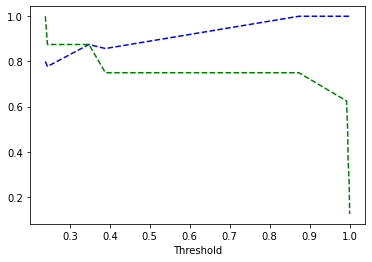

In [12]:
au_labels, au_preds = labels[:, 0], preds[:, 0]
precisions, recalls, thresholds = precision_recall_curve(au_labels, au_preds)
auc_precision_recall = auc(recalls, precisions)
print(auc_precision_recall)
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
plt.xlabel("Threshold")

In [13]:
au_preds_t = (au_preds > 0.9) * 1
print(f'Precision: {precision_score(au_labels, au_preds_t)}')
print(f'Recall: {recall_score(au_labels, au_preds_t)}')

Precision: 1.0
Recall: 0.625


### AU 2

0.864367816091954


Text(0.5, 0, 'Threshold')

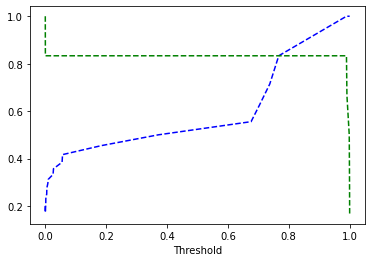

In [14]:
au_labels, au_preds = labels[:, 1], preds[:, 1]
precisions, recalls, thresholds = precision_recall_curve(au_labels, au_preds)
auc_precision_recall = auc(recalls, precisions)
print(auc_precision_recall)
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
plt.xlabel("Threshold")

In [15]:
au_preds_t = (au_preds > 0.6) * 1
print(f'Precision: {precision_score(au_labels, au_preds_t)}')
print(f'Recall: {recall_score(au_labels, au_preds_t)}')

Precision: 0.5555555555555556
Recall: 0.8333333333333334


### AU 4

0.9037698412698413


Text(0.5, 0, 'Threshold')

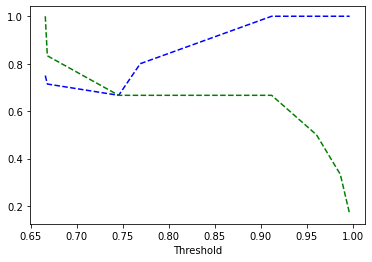

In [16]:
au_labels, au_preds = labels[:, 2], preds[:, 2]
precisions, recalls, thresholds = precision_recall_curve(au_labels, au_preds)
auc_precision_recall = auc(recalls, precisions)
print(auc_precision_recall)
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
plt.xlabel("Threshold")

In [17]:
au_preds_t = (au_preds > 0.75) * 1
print(f'Precision: {precision_score(au_labels, au_preds_t)}')
print(f'Recall: {recall_score(au_labels, au_preds_t)}')

Precision: 0.8
Recall: 0.6666666666666666


### AU 5

1.0


Text(0.5, 0, 'Threshold')

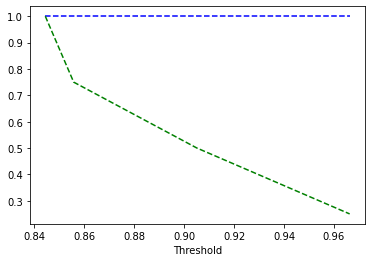

In [18]:
au_labels, au_preds = labels[:, 3], preds[:, 3]
precisions, recalls, thresholds = precision_recall_curve(au_labels, au_preds)
auc_precision_recall = auc(recalls, precisions)
print(auc_precision_recall)
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
plt.xlabel("Threshold")

In [19]:
au_preds_t = (au_preds > 0.5) * 1
print(f'Precision: {precision_score(au_labels, au_preds_t)}')
print(f'Recall: {recall_score(au_labels, au_preds_t)}')

Precision: 1.0
Recall: 1.0


### AU 6

0.8837868480725624


Text(0.5, 0, 'Threshold')

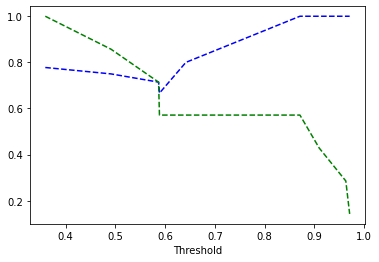

In [20]:
au_labels, au_preds = labels[:, 4], preds[:, 4]
precisions, recalls, thresholds = precision_recall_curve(au_labels, au_preds)
auc_precision_recall = auc(recalls, precisions)
print(auc_precision_recall)
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
plt.xlabel("Threshold")

In [21]:
au_preds_t = (au_preds > 0.5) * 1
print(f'Precision: {precision_score(au_labels, au_preds_t)}')
print(f'Recall: {recall_score(au_labels, au_preds_t)}')

Precision: 0.7142857142857143
Recall: 0.7142857142857143


### AU 7

0.7548611111111111


Text(0.5, 0, 'Threshold')

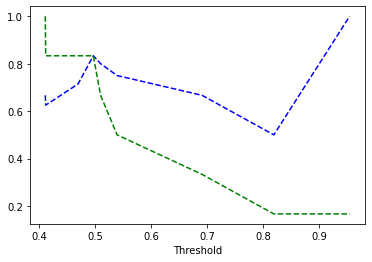

In [22]:
au_labels, au_preds = labels[:, 5], preds[:, 5]
precisions, recalls, thresholds = precision_recall_curve(au_labels, au_preds)
auc_precision_recall = auc(recalls, precisions)
print(auc_precision_recall)
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
plt.xlabel("Threshold")

In [23]:
au_preds_t = (au_preds > 0.55) * 1
print(f'Precision: {precision_score(au_labels, au_preds_t)}')
print(f'Recall: {recall_score(au_labels, au_preds_t)}')

Precision: 0.6666666666666666
Recall: 0.3333333333333333


### AU 9

1.0


Text(0.5, 0, 'Threshold')

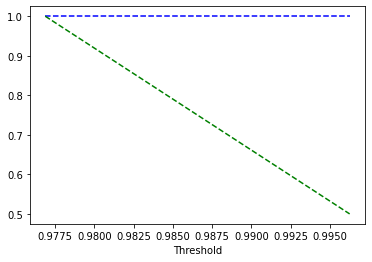

In [24]:
au_labels, au_preds = labels[:, 6], preds[:, 6]
precisions, recalls, thresholds = precision_recall_curve(au_labels, au_preds)
auc_precision_recall = auc(recalls, precisions)
print(auc_precision_recall)
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
plt.xlabel("Threshold")

In [25]:
au_preds_t = (au_preds > 0.25) * 1
print(f'Precision: {precision_score(au_labels, au_preds_t)}')
print(f'Recall: {recall_score(au_labels, au_preds_t)}')

Precision: 1.0
Recall: 1.0


### AU 10

1.0


Text(0.5, 0, 'Threshold')

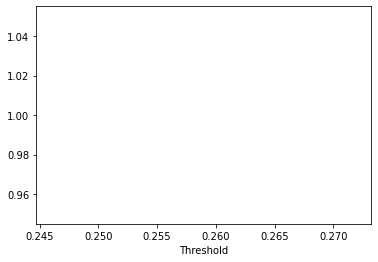

In [26]:
au_labels, au_preds = labels[:, 7], preds[:, 7]
precisions, recalls, thresholds = precision_recall_curve(au_labels, au_preds)
auc_precision_recall = auc(recalls, precisions)
print(auc_precision_recall)
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
plt.xlabel("Threshold")

In [27]:
au_preds_t = (au_preds > 0.2) * 1
print(f'Precision: {precision_score(au_labels, au_preds_t)}')
print(f'Recall: {recall_score(au_labels, au_preds_t)}')

Precision: 0.5
Recall: 1.0


### AU 12

1.0


Text(0.5, 0, 'Threshold')

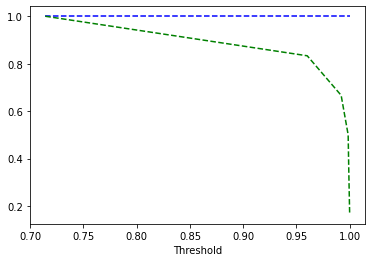

In [28]:
au_labels, au_preds = labels[:, 8], preds[:, 8]
precisions, recalls, thresholds = precision_recall_curve(au_labels, au_preds)
auc_precision_recall = auc(recalls, precisions)
print(auc_precision_recall)
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
plt.xlabel("Threshold")

In [29]:
au_preds_t = (au_preds > 0.75) * 1
print(f'Precision: {precision_score(au_labels, au_preds_t)}')
print(f'Recall: {recall_score(au_labels, au_preds_t)}')

Precision: 1.0
Recall: 0.8333333333333334


### AU 14

0.25


Text(0.5, 0, 'Threshold')

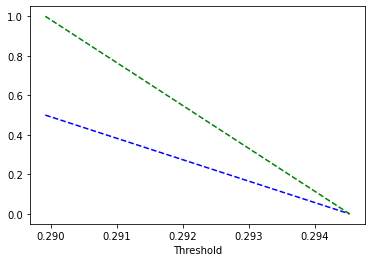

In [30]:
au_labels, au_preds = labels[:, 9], preds[:, 9]
precisions, recalls, thresholds = precision_recall_curve(au_labels, au_preds)
auc_precision_recall = auc(recalls, precisions)
print(auc_precision_recall)
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
plt.xlabel("Threshold")

In [31]:
au_preds_t = (au_preds > 0.45) * 1
print(f'Precision: {precision_score(au_labels, au_preds_t)}')
print(f'Recall: {recall_score(au_labels, au_preds_t)}')

Precision: 0.0
Recall: 0.0


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### AU 15

0.8500000000000001


Text(0.5, 0, 'Threshold')

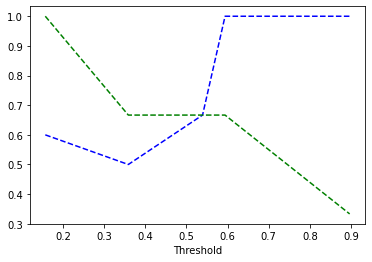

In [32]:
au_labels, au_preds = labels[:, 10], preds[:, 10]
precisions, recalls, thresholds = precision_recall_curve(au_labels, au_preds)
auc_precision_recall = auc(recalls, precisions)
print(auc_precision_recall)
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
plt.xlabel("Threshold")

In [33]:
au_preds_t = (au_preds > 0.7) * 1
print(f'Precision: {precision_score(au_labels, au_preds_t)}')
print(f'Recall: {recall_score(au_labels, au_preds_t)}')

Precision: 1.0
Recall: 0.3333333333333333


### AU 17

0.9852430555555556


Text(0.5, 0, 'Threshold')

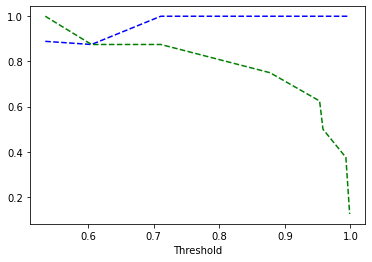

In [34]:
au_labels, au_preds = labels[:, 11], preds[:, 11]
precisions, recalls, thresholds = precision_recall_curve(au_labels, au_preds)
auc_precision_recall = auc(recalls, precisions)
print(auc_precision_recall)
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
plt.xlabel("Threshold")

In [35]:
au_preds_t = (au_preds > 0.65) * 1
print(f'Precision: {precision_score(au_labels, au_preds_t)}')
print(f'Recall: {recall_score(au_labels, au_preds_t)}')

Precision: 1.0
Recall: 0.875


### AU 20

0.7916666666666666


Text(0.5, 0, 'Threshold')

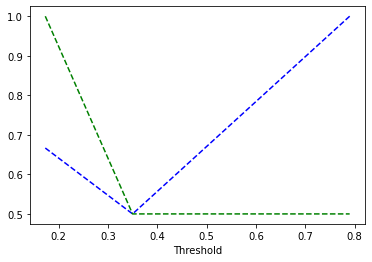

In [36]:
au_labels, au_preds = labels[:, 12], preds[:, 12]
precisions, recalls, thresholds = precision_recall_curve(au_labels, au_preds)
auc_precision_recall = auc(recalls, precisions)
print(auc_precision_recall)
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
plt.xlabel("Threshold")

In [37]:
au_preds_t = (au_preds > 0.75) * 1
print(f'Precision: {precision_score(au_labels, au_preds_t)}')
print(f'Recall: {recall_score(au_labels, au_preds_t)}')

Precision: 1.0
Recall: 0.5


### AU 23/24

0.711111111111111


Text(0.5, 0, 'Threshold')

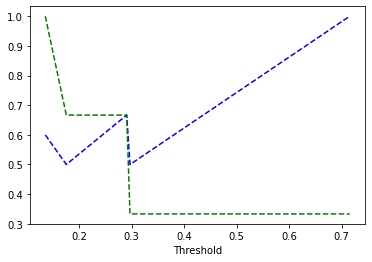

In [38]:
au_labels, au_preds = labels[:, 13], preds[:, 13]
precisions, recalls, thresholds = precision_recall_curve(au_labels, au_preds)
auc_precision_recall = auc(recalls, precisions)
print(auc_precision_recall)
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
plt.xlabel("Threshold")

In [39]:
au_preds_t = (au_preds > 0.3) * 1
print(f'Precision: {precision_score(au_labels, au_preds_t)}')
print(f'Recall: {recall_score(au_labels, au_preds_t)}')

Precision: 1.0
Recall: 0.3333333333333333


### AU 25

0.9410981558270162


Text(0.5, 0, 'Threshold')

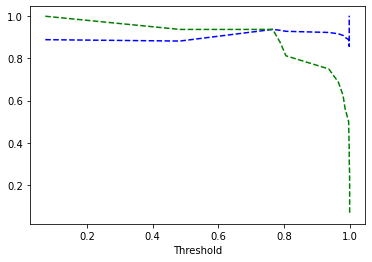

In [40]:
au_labels, au_preds = labels[:, 14], preds[:, 14]
precisions, recalls, thresholds = precision_recall_curve(au_labels, au_preds)
auc_precision_recall = auc(recalls, precisions)
print(auc_precision_recall)
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
plt.xlabel("Threshold")

In [41]:
au_preds_t = (au_preds > 0.8) * 1
print(f'Precision: {precision_score(au_labels, au_preds_t)}')
print(f'Recall: {recall_score(au_labels, au_preds_t)}')

Precision: 0.9285714285714286
Recall: 0.8125


### AU 26/27

0.8655067155067153


Text(0.5, 0, 'Threshold')

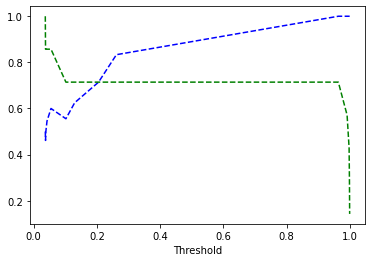

In [42]:
au_labels, au_preds = labels[:, 15], preds[:, 15]
precisions, recalls, thresholds = precision_recall_curve(au_labels, au_preds)
auc_precision_recall = auc(recalls, precisions)
print(auc_precision_recall)
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
plt.xlabel("Threshold")

In [43]:
au_preds_t = (au_preds > 0.5) * 1
print(f'Precision: {precision_score(au_labels, au_preds_t)}')
print(f'Recall: {recall_score(au_labels, au_preds_t)}')

Precision: 1.0
Recall: 0.7142857142857143


## **Final Model Scores**

In [ ]:
def get_metrics(model, data):
  """
  Compute the f1 score for each action unit (AU).
  """
  labels = np.array([], dtype=int).reshape(0,18)
  preds = np.array([], dtype=int).reshape(0,18)
  thresholds = np.array([0.9, 0.6, 0.75, 0.5, 0.5, 0.5, 0.25, 0.2, 0.75, 0.45, # New thresholds
                          0.7, 0.65, 0.75, 0.3, 0.8, 0.5, 0.9, 0.1])
  model.eval() # Set to evaluation mode
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  model.to(device)

  with torch.no_grad():
    for _, item in enumerate(data, 0):
      batch_labels = item.get("labels")
      labels = np.vstack([labels, batch_labels])
      imgs = item.get("image")
      imgs = imgs.to(device)
      outputs = model(imgs).cpu().detach()
      outputs = torch.sigmoid(outputs).numpy()
      preds = np.vstack([preds, outputs])
  
  # Compute f1 scores
  f1_scores = []
  pres_scores = []
  recall_scores = []
  pr_auc_scores = []
  for au in range(18):
    au_labels = labels[:, au]
    au_preds = preds[:, au]
    p, r, _ = precision_recall_curve(au_labels, au_preds)
    auc_pr = auc(r, p)
    if np.isnan(auc_pr):
      auc_pr = 0
    pr_auc_scores.append(auc_pr)


    # Threshold probabilities > threshold to 1 for other metrics
    au_preds = (au_preds > thresholds[au]) * 1
    f1 = f1_score(au_labels, au_preds, zero_division=0); f1_scores.append(f1)
    precision = precision_score(au_labels, au_preds, zero_division=0)
    pres_scores.append(precision)
    recall = recall_score(au_labels, au_preds, zero_division=0)
    recall_scores.append(recall)
  return pres_scores, recall_scores, f1_scores, pr_auc_scores

In [ ]:
convnet = get_model('/content/drive/MyDrive/training/checkpoints/final.pt')
# Instantiate dataloader
dataset = AUDataset(mode='test', fold=0, transform=transform)
data = DataLoader(dataset, 32, collate_fn=collate_fn, shuffle=True, 
           num_workers=4)

# Compute scores
precision, recall, f1, roc_auc = get_metrics(convnet, data)
for i in range(18):
  print(f'{dataset.label_cols[i]}: precision: {precision[i]:.3f}, recall: {recall[i]:.3f}, F1: {f1[i]:.3f}, PR AUC: {roc_auc[i]:.3f}')
print(f'mean precision: {np.mean(precision):.3f}, mean recall: {np.mean(recall):.3f}, mean F1: {np.mean(f1):.3f}, mean PR-AUC: {np.mean(roc_auc):.3f}')

AU_1: precision: 0.867, recall: 0.867, F1: 0.867, PR AUC: 0.971
AU_2: precision: 0.900, recall: 0.750, F1: 0.818, PR AUC: 0.874
AU_4: precision: 0.875, recall: 0.824, F1: 0.848, PR AUC: 0.927
AU_5: precision: 0.900, recall: 0.750, F1: 0.818, PR AUC: 0.882
AU_6: precision: 1.000, recall: 0.600, F1: 0.750, PR AUC: 0.789
AU_7: precision: 0.600, recall: 0.750, F1: 0.667, PR AUC: 0.723
AU_9: precision: 1.000, recall: 0.800, F1: 0.889, PR AUC: 1.000
AU_10: precision: 1.000, recall: 1.000, F1: 1.000, PR AUC: 1.000
AU_12: precision: 0.875, recall: 0.700, F1: 0.778, PR AUC: 0.808
AU_14: precision: 1.000, recall: 0.143, F1: 0.250, PR AUC: 0.690
AU_15: precision: 0.889, recall: 0.727, F1: 0.800, PR AUC: 0.956
AU_17: precision: 0.889, recall: 0.842, F1: 0.865, PR AUC: 0.958
AU_20: precision: 1.000, recall: 0.750, F1: 0.857, PR AUC: 1.000
AU_23/24: precision: 1.000, recall: 0.875, F1: 0.933, PR AUC: 0.944
AU_25: precision: 0.923, recall: 0.889, F1: 0.906, PR AUC: 0.948
AU_26/27: precision: 0.889, r

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:677: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
